# Gaussian process regression

[Section 1](01-bayesian_regression.ipynb) derived linear regression in a Bayesian context. Here, we discuss Gaussian process regression using `GPy` and `scipy`.

In [67]:
import GPy
import scipy
from sklearn.metrics.pairwise import rbf_kernel

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

GPy.plotting.change_plotting_library('plotly')

/Users/simondi/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning:

As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.



### Priors on functions

In Bayesian linear regression we assumed a linear dependency

\begin{align*}
f_{\boldsymbol \beta}& :  \ \mathcal{X} \rightarrow \mathcal{Y},\\
f_{\boldsymbol \beta}(\mathbf{x}) & =  \ \mathbf{x}^T \boldsymbol \beta + \epsilon,
\end{align*}

which was parametrized by a coefficient vector $\boldsymbol \beta$. 
In order to model uncertainty, regularize our coeffiencts, or what reason whatsoever, we put a prior distribution on $\boldsymbol \beta$ and by that introduced some prior belief to the model.

When we use Gaussian Processes, we instead set a prior on the function $f$ itself:

\begin{align*}
f(\mathbf{x}) & \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')) ,\\
p(f \mid \mathbf{x}) & = \mathcal{N}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')) .
\end{align*}

So a Gaussian process is a distribution of functions. It is parametrized by a *mean function* $m$ that returns a vector of length $n$ and a *kernel function* $k$ that returns a matrix of dimension $n \times n$, where $n$ is the number of samples. For instance, the mean function could be a constant (which we will assume throughout the rest of this notebook), and the kernel could be a radial basis function, i.e.:

\begin{align*}
m(\mathbf{x}) &= \mathbf{0},\\
k(\mathbf{x}, \mathbf{x}') &= \exp\left(- \gamma ||\mathbf{x} - \mathbf{x}' ||^2 \right),
\end{align*}

where $\gamma$ a hyperparameter we have to optimize. 


The parameters $\mathbf{m}$ and $\mathbf{k}$  apparently do not have a fixed dimensionality as in Bayesian linear regression (where we had $\boldsymbol \beta \in \mathbb{R}^p$), but have possibly infinite dimension. That means with more data, the dimensions if $\mathbf{m}$ and $\mathbf{k}$ increase (in Bayesian regression $\boldsymbol \beta$ was independent of the sample size $n$). For that reason we call this approach *non-parametric* (the turn itself sounds confusing, because we apparently *have* parameters).

Let's vizualize some samples of a Gaussian process with mean function $\mathbf{m}$ and covariance $\mathbf{k}$. First we create some data.

In [150]:
n = 1000
x = scipy.stats.norm.rvs(size=n).reshape((n, 1))

Then we set the mean and covariance functions.

In [151]:
gamma = 2
m = scipy.zeros(n)
k = rbf_kernel(x, gamma=2)

Then we sample five functions from the Gaussian process

In [153]:
f_prior = [scipy.stats.multivariate_normal.rvs(mean=m, cov=k) for i in range(5)]

...and we plot the five samples.

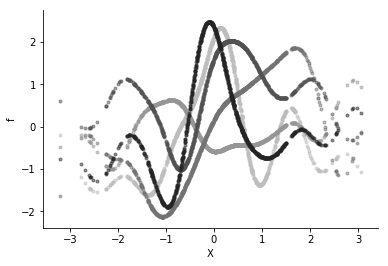

In [156]:
colors = ['#bdbdbd','#969696','#737373','#525252','#252525']
_, ax = plt.subplots()
for i in range(5):
    ax.scatter(x, f_prior[i], color=colors[i], marker=".", alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("X")
plt.ylabel("f")
plt.show()

### Posterior Gaussian process

The posterior Gaussian process is given by

\begin{align*}
\text{posterior} \propto \text{likelihood} \times \text{prior}.
\end{align*}

We haven't specified the likelihood it yet which we will assume to be Gaussian:

\begin{align*}
p(\mathbf{y} \mid f, \mathbf{x}) = \prod_i^n \mathcal{N}(f_i, \sigma^2 \mathbf{I} ).
\end{align*}

Later, for classification, we will also use a binomial likelihood. Thus the posterior has the following form:

\begin{align*}
p(f \mid \mathbf{y}, \mathbf{x}) & \propto p(\mathbf{y} \mid f, \mathbf{x}) \ p(f),\\
f \mid \mathbf{y}, \mathbf{x} & \sim \mathcal{GP}(\tilde{m}(\tilde{\mathbf{x}}), \tilde{k}(\tilde{\mathbf{x}}, \tilde{\mathbf{x}}')),\\\\
\tilde{m}(\tilde{\mathbf{x}}) & = k(\tilde{\mathbf{x}}, \mathbf{x})\left( k(\mathbf{x}, \mathbf{x}) + \sigma^2 \mathbf{I}   \right)^{-1} \mathbf{y},\\
\tilde{k}(\tilde{\mathbf{x}}, \tilde{\mathbf{x}}')  & = k(\tilde{\mathbf{x}}, \tilde{\mathbf{x}}') - k(\tilde{\mathbf{x}}, \mathbf{x}) \left( k(\mathbf{x}, \mathbf{x}) + \sigma^2 \mathbf{I}  \right)^{-1} k(\mathbf{x}, \tilde{\mathbf{x}}')
\end{align*}

So the posterior is again a Gaussian process with modified mean and variance functions.

The joint distribution of observed noisy target values $\mathbf{y}$ and unobserved function values ${f}^*$ is then given by:
\begin{align*}
\left[
\begin{array}{c}
\mathbf{y} \\
{f}^*
\end{array}
\right] =
\mathcal{N} \left(  \mathbf{0},
\begin{array}{cc}
 \kappa(\mathbf{x}, \mathbf{x})  + \sigma \mathbf{I} &  \kappa(\mathbf{x}, {x}^*) \\
\kappa({x}^*, \mathbf{x}) & \kappa({x}^*, {x}^*)
\end{array}
  \right).
\end{align*}

In [127]:

beta = 2

y = scipy.sin(x) * beta + scipy.stats.norm.rvs(size=(n, 1), scale=1)

This simple example we can actually solve with linear regression, since the dependency is *linear in the parameters*.
We only need to modify our features $\mathbf{x}$ appropriately.

In [128]:
import sklearn.linear_model
fit = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(scipy.sin(x), y)
print("Beta estimated:", fit.coef_)

Beta estimated: [[2.02356323]]


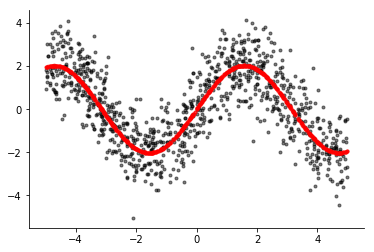

In [130]:
_, ax = plt.subplots()
ax.scatter(x, y, color="black", marker=".", alpha=0.5)
ax.scatter(x, scipy.sin(x) * fit.coef_[0], color="red", alpha=0.5, marker=".")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Next, let's look at some *prior functions* $f$. A prior function is just a sample from a $n$-dimensional multivariate normal distribution with mean $\mathbf{m}$ and variance $\mathbf{k}$. The kernel must be postive definite, which the *RBF* kernel is.

This does not look like our data set at all. The reason is that we did not consider the responses $\mathbf{y}$ in the model. We do this by multiplying the prior with the likelihood, which gives us the posterior Gaussian process.

### Predictive posterior

Accordingly the predictive distribution is given by:
\begin{align}
P(f^* \mid {x}^*, \mathbf{x}, \mathbf{y} )  & =  \int P(f^* \mid {x}^*, \mathbf{x}, \mathbf{f} ) p(\mathbf{f} \mid \mathbf{x}, \mathbf{y} ) d \mathbf{f}  \\
f^* \mid  x^*, \mathbf{x}, \mathbf{y} &  \sim \mathcal{N}(\bar{f}^*, \boldsymbol{\Sigma}^*) \\
\bar{f}^* & = \kappa({x}^*, \mathbf{x}) \kappa(\mathbf{x}, \mathbf{x})^{-1} \mathbf{y} \\
 \boldsymbol{\Sigma}^* & = \kappa({x}^*, {x}^*)  - \kappa({x}^*, \mathbf{x}) \kappa(\mathbf{x}, \mathbf{x})^{-1} \kappa(\mathbf{x}, {x}^*)
\end{align}

In [52]:
kernel = GPy.kern.RBF(input_dim=x.shape[1], variance=1., lengthscale=1.)
m = GPy.models.GPRegression(x, y, kernel)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,
